# `CNModel` Hyperfine Anomalies

Trey V. Wenger (c) April 2025

`CNModel` can also account for a full physical treatment of non-LTE and non-CTEX effects. That is, it can model situations where the excitation temperature is *not* equal to the kinetic temperature, and the excitation temperature is not the same for each transition. `CNModel` considers the detailed balance between all transitions in the `mol_data` dictionary. For ${\rm CN}$ this includes all of the $N=1-0$ ($\nu = 0$) hyperfine transitions at 113.15 and 113.5 GHz, and for $^{13}{\rm CN}$ this includes all of the $N=1-0$ hyperfine transitions at 108.06 GHz, 108.4 GHz, 108.6 GHz, 108.8 GHz, and 109.2 GHz. Each state's statistical weight is a free parameter.

We fix the kinetic temperature for these models, since we are unable to constrain the thermal line width.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.8
bayes_cn_hfs version: 2.0.0-staging+0.g7afe3a8.dirty


## Simulate data

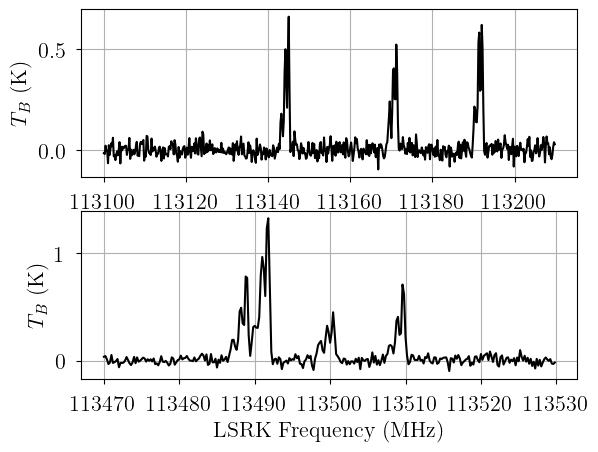

In [2]:
from bayes_cn_hfs import supplement_mol_data
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_log10_LTE_precision = [-6.0, 1.0], # offset and width of log10 LTE precision prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N": [13.8, 13.9, 14.0],
    "log10_Tkin": [0.65, 0.6, 0.5],
    "fwhm_nonthermal": [1.0, 1.25, 1.5],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "log10_Tex_ul": [0.65, 0.6, 0.5],
    "log10_LTE_precision": [-3.0, -4.0, -5.0],
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_freeRVs + model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [3]:
sim_params

{'log10_N': [13.8, 13.9, 14.0],
 'log10_Tkin': [0.65, 0.6, 0.5],
 'fwhm_nonthermal': [1.0, 1.25, 1.5],
 'velocity': [-2.0, 0.0, 2.5],
 'fwhm_L': 0.0,
 'log10_Tex_ul': [0.65, 0.6, 0.5],
 'log10_LTE_precision': [-3.0, -4.0, -5.0],
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'velocity_norm': array([-0.90725257, -1.08963228,  2.05844579]),
 'log10_Tkin_norm': array([-1.22839729, -0.1382073 ,  2.11081962]),
 'fwhm_nonthermal_norm': array([1.14100359, 0.72364694, 0.19993961]),
 'log10_N_norm': array([-0.19739975,  1.18167855,  0.09680737]),
 'log10_Tex_ul_norm': array([-0.0689338 ,  0.12648815, -1.16190854]),
 'log10_LTE_precision_norm': array([0.21987947, 0.71222726, 2.31970483]),
 'weights': array([[0.17274399, 0.346758  , 0.05395841, 0.10043034, 0.04519759,
         0.11536218, 0.16554947],
        [0.19248324, 0.38011643, 0.04867468, 0.0963955 , 0.0423153 ,
         0.09213565, 0.14787919],
        [0.21685544, 0.43456298, 0.03896576, 0.07729498, 0.0381383 ,
        

## Model Definition

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = None, # ignored (kinetic temperature is fixed)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_log10_LTE_precision = [-6.0, 1.0], # offset and width of log10 LTE precision prior
    fix_log10_Tkin = 0.5, # fix the kinetic temperature
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_nonthermal_norm, log10_LTE_precision_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


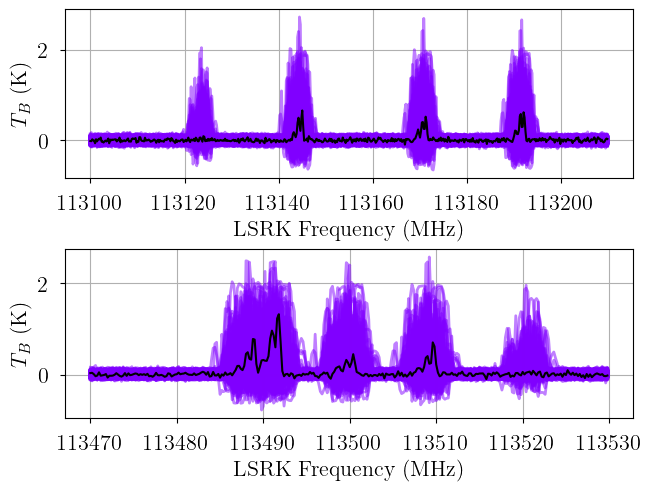

In [5]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

baseline_freeRVs ['baseline_12CN-1_norm', 'baseline_12CN-2_norm']
baseline_deterministics []
cloud_freeRVs ['velocity_norm', 'fwhm_nonthermal_norm', 'log10_N_norm', 'log10_Tex_ul_norm', 'log10_LTE_precision_norm', 'weights']
cloud_deterministics ['velocity', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'LTE_weights', 'log10_LTE_precision', 'Tex', 'tau', 'tau_total', 'TR']
hyper_freeRVs []
hyper_deterministics []


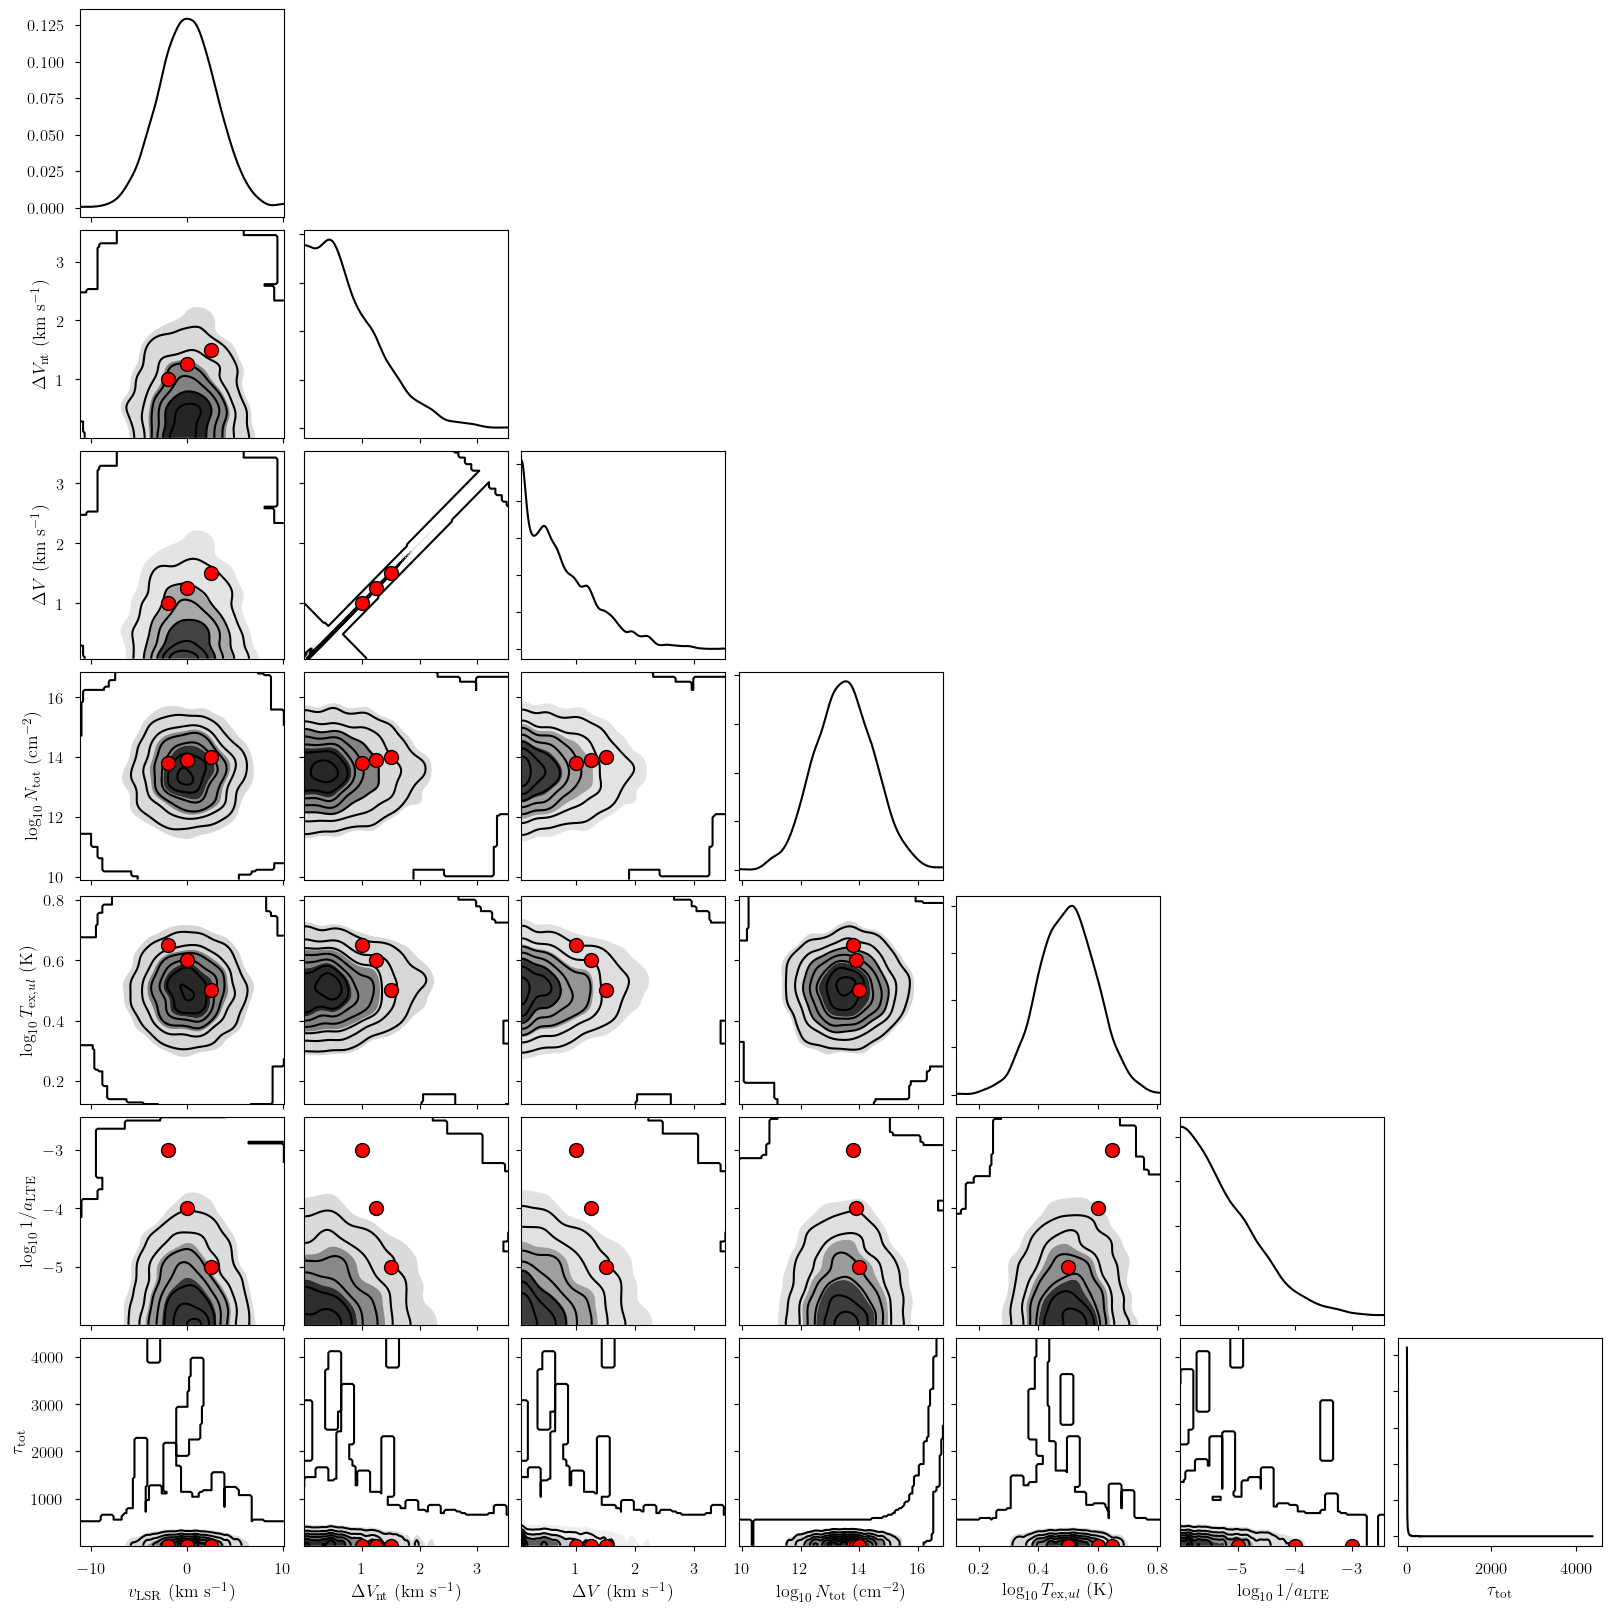

In [6]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

In [7]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.05, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 12500
Interrupted at 12,499 [12%]: Average Loss = 1.9687e+24


Output()

Runtime: 0.38 minutes


Sampling: [12CN-1, 12CN-2]


Output()

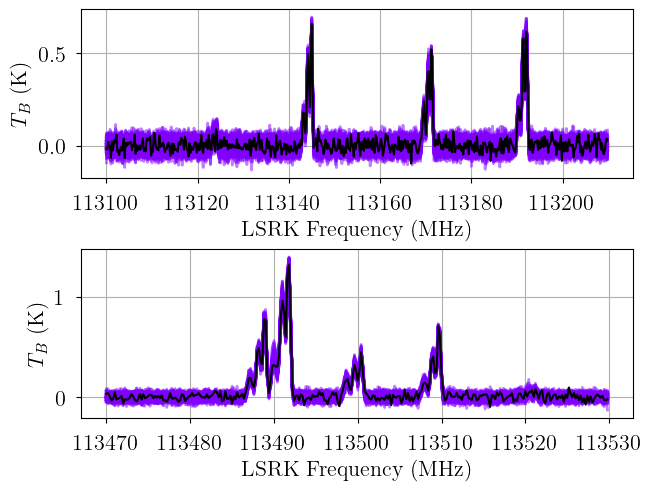

In [8]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [26]:
start = time.time()
init_kwargs = {
    "rel_tolerance": 0.05,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = init_kwargs, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 12500
Interrupted at 12,499 [12%]: Average Loss = 1.9687e+24
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, log10_LTE_precision_norm, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 257 seconds.


Adding log-likelihood to trace


Output()

Runtime: 4.78 minutes


In [27]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

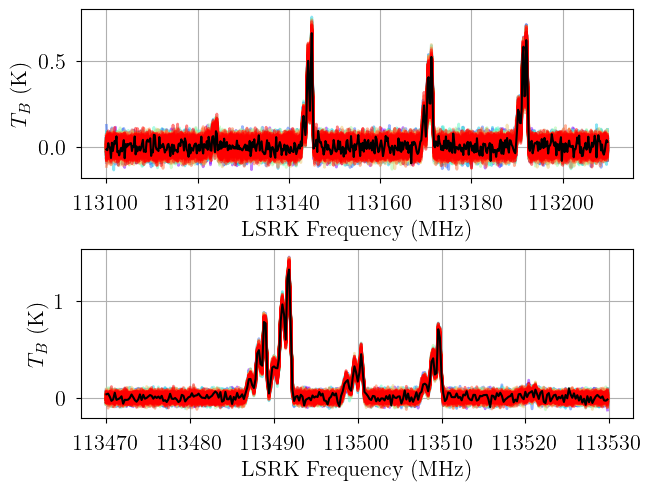

In [28]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [29]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1_norm[0]      -0.076  0.044  -0.160    0.005      0.000   
baseline_12CN-2_norm[0]      -0.435  0.064  -0.556   -0.317      0.001   
velocity_norm[0]              0.852  0.013   0.828    0.879      0.000   
velocity_norm[1]             -0.002  0.005  -0.011    0.008      0.000   
velocity_norm[2]             -0.663  0.003  -0.670   -0.658      0.000   
log10_N_norm[0]               0.393  0.082   0.238    0.549      0.002   
log10_N_norm[1]               0.363  0.065   0.244    0.485      0.001   
log10_N_norm[2]               0.324  0.050   0.230    0.420      0.001   
log10_Tex_ul_norm[0]          0.089  0.101  -0.093    0.270      0.002   
log10_Tex_ul_norm[1]          1.128  0.221   0.733    1.560      0.005   
log10_Tex_ul_norm[2]          1.546  0.249   1.080    2.012      0.005   
fwhm_nonthermal_norm[0]       1.580  0.102   1.389    1.772      0.001   
fwhm_nonthermal_norm[1]       1.312  0.058   1.203    1.421      0.001   
fwhm_nonthermal_norm[2]       0.980  0.034   0.920    1.049      0.001   
log10_LTE_precision_norm[0]   0.780  0.520   0.000    1.662      0.013   
log10_LTE_precision_norm[1]   2.244  0.283   1.728    2.790      0.004   
log10_LTE_precision_norm[2]   2.692  0.244   2.247    3.151      0.003   
weights[0, 0 0 1 1]           0.214  0.003   0.208    0.220      0.000   
weights[0, 0 0 1 2]           0.429  0.006   0.418    0.440      0.000   
weights[0, 1 0 1 1]           0.040  0.001   0.037    0.042      0.000   
weights[0, 1 0 1 2]           0.080  0.002   0.076    0.084      0.000   
weights[0, 1 0 2 1]           0.040  0.001   0.037    0.042      0.000   
weights[0, 1 0 2 2]           0.079  0.002   0.075    0.083      0.000   
weights[0, 1 0 2 3]           0.119  0.003   0.115    0.124      0.000   
weights[1, 0 0 1 1]           0.189  0.006   0.177    0.200      0.000   
weights[1, 0 0 1 2]           0.368  0.010   0.348    0.385      0.000   
weights[1, 1 0 1 1]           0.051  0.003   0.047    0.056      0.000   
weights[1, 1 0 1 2]           0.101  0.005   0.092    0.109      0.000   
weights[1, 1 0 2 1]           0.044  0.002   0.040    0.048      0.000   
weights[1, 1 0 2 2]           0.097  0.004   0.089    0.104      0.000   
weights[1, 1 0 2 3]           0.150  0.003   0.145    0.156      0.000   
weights[2, 0 0 1 1]           0.178  0.005   0.168    0.188      0.000   
weights[2, 0 0 1 2]           0.346  0.009   0.329    0.363      0.000   
weights[2, 1 0 1 1]           0.054  0.002   0.049    0.058      0.000   
weights[2, 1 0 1 2]           0.098  0.003   0.092    0.104      0.000   
weights[2, 1 0 2 1]           0.045  0.002   0.042    0.049      0.000   
weights[2, 1 0 2 2]           0.116  0.005   0.107    0.125      0.000   
weights[2, 1 0 2 3]           0.163  0.002   0.159    0.167      0.000   
velocity[0]                   2.557  0.040   2.484    2.636      0.000   
velocity[1]                  -0.005  0.015  -0.034    0.023      0.000   
velocity[2]                  -1.990  0.010  -2.009   -1.973      0.000   
fwhm_thermal[0]               0.075  0.000   0.075    0.075      0.000   
fwhm_thermal[1]               0.075  0.000   0.075    0.075      0.000   
fwhm_thermal[2]               0.075  0.000   0.075    0.075      0.000   
fwhm_nonthermal[0]            1.580  0.102   1.389    1.772      0.001   
fwhm_nonthermal[1]            1.312  0.058   1.203    1.421      0.001   
fwhm_nonthermal[2]            0.980  0.034   0.920    1.049      0.001   
fwhm[0]                       1.581  0.102   1.391    1.774      0.001   
fwhm[1]                       1.314  0.058   1.205    1.423      0.001   
fwhm[2]                       0.983  0.034   0.923    1.052      0.001   
log10_N[0]                   13.893  0.082  13.738   14.049      0.002   
log10_N[1]                   13.863  0.065  13.744   13.985      0.001   
log10_N[2]                   13.824  0.050  13.730   13.920      0.001   
log10_Tex_ul[0]               0.509

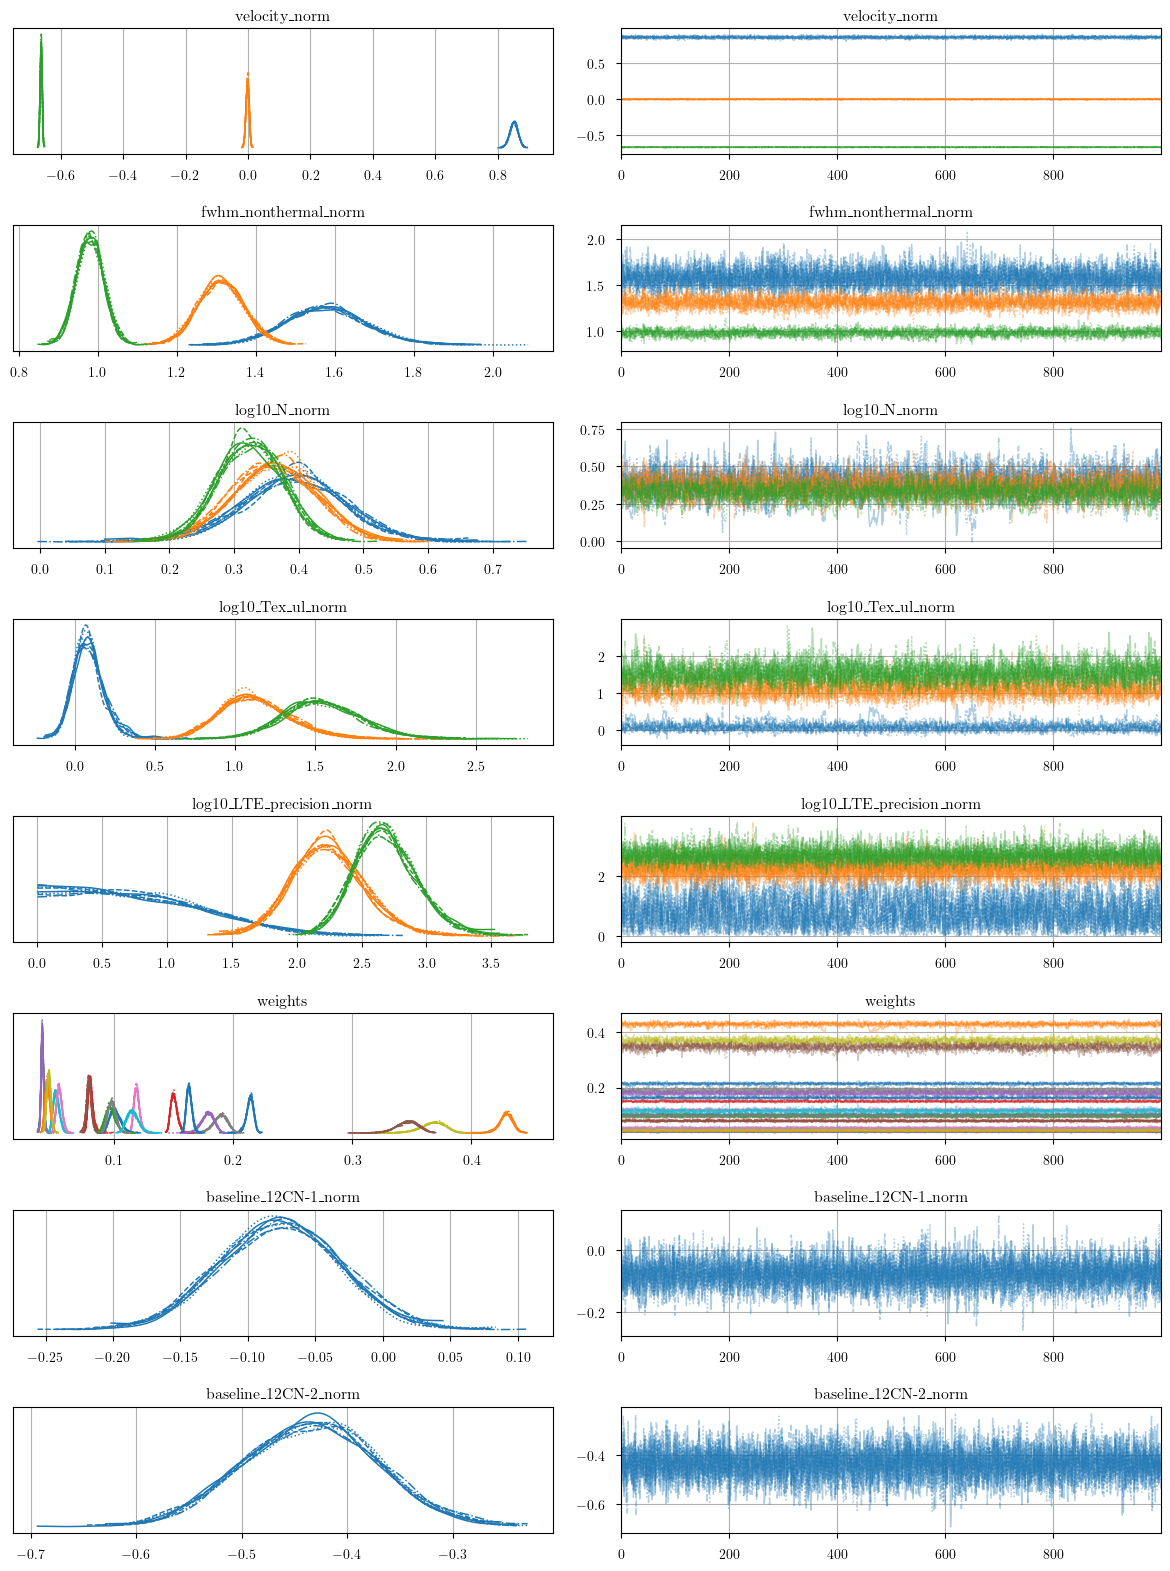

In [30]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

['velocity', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'log10_LTE_precision', 'tau_total']


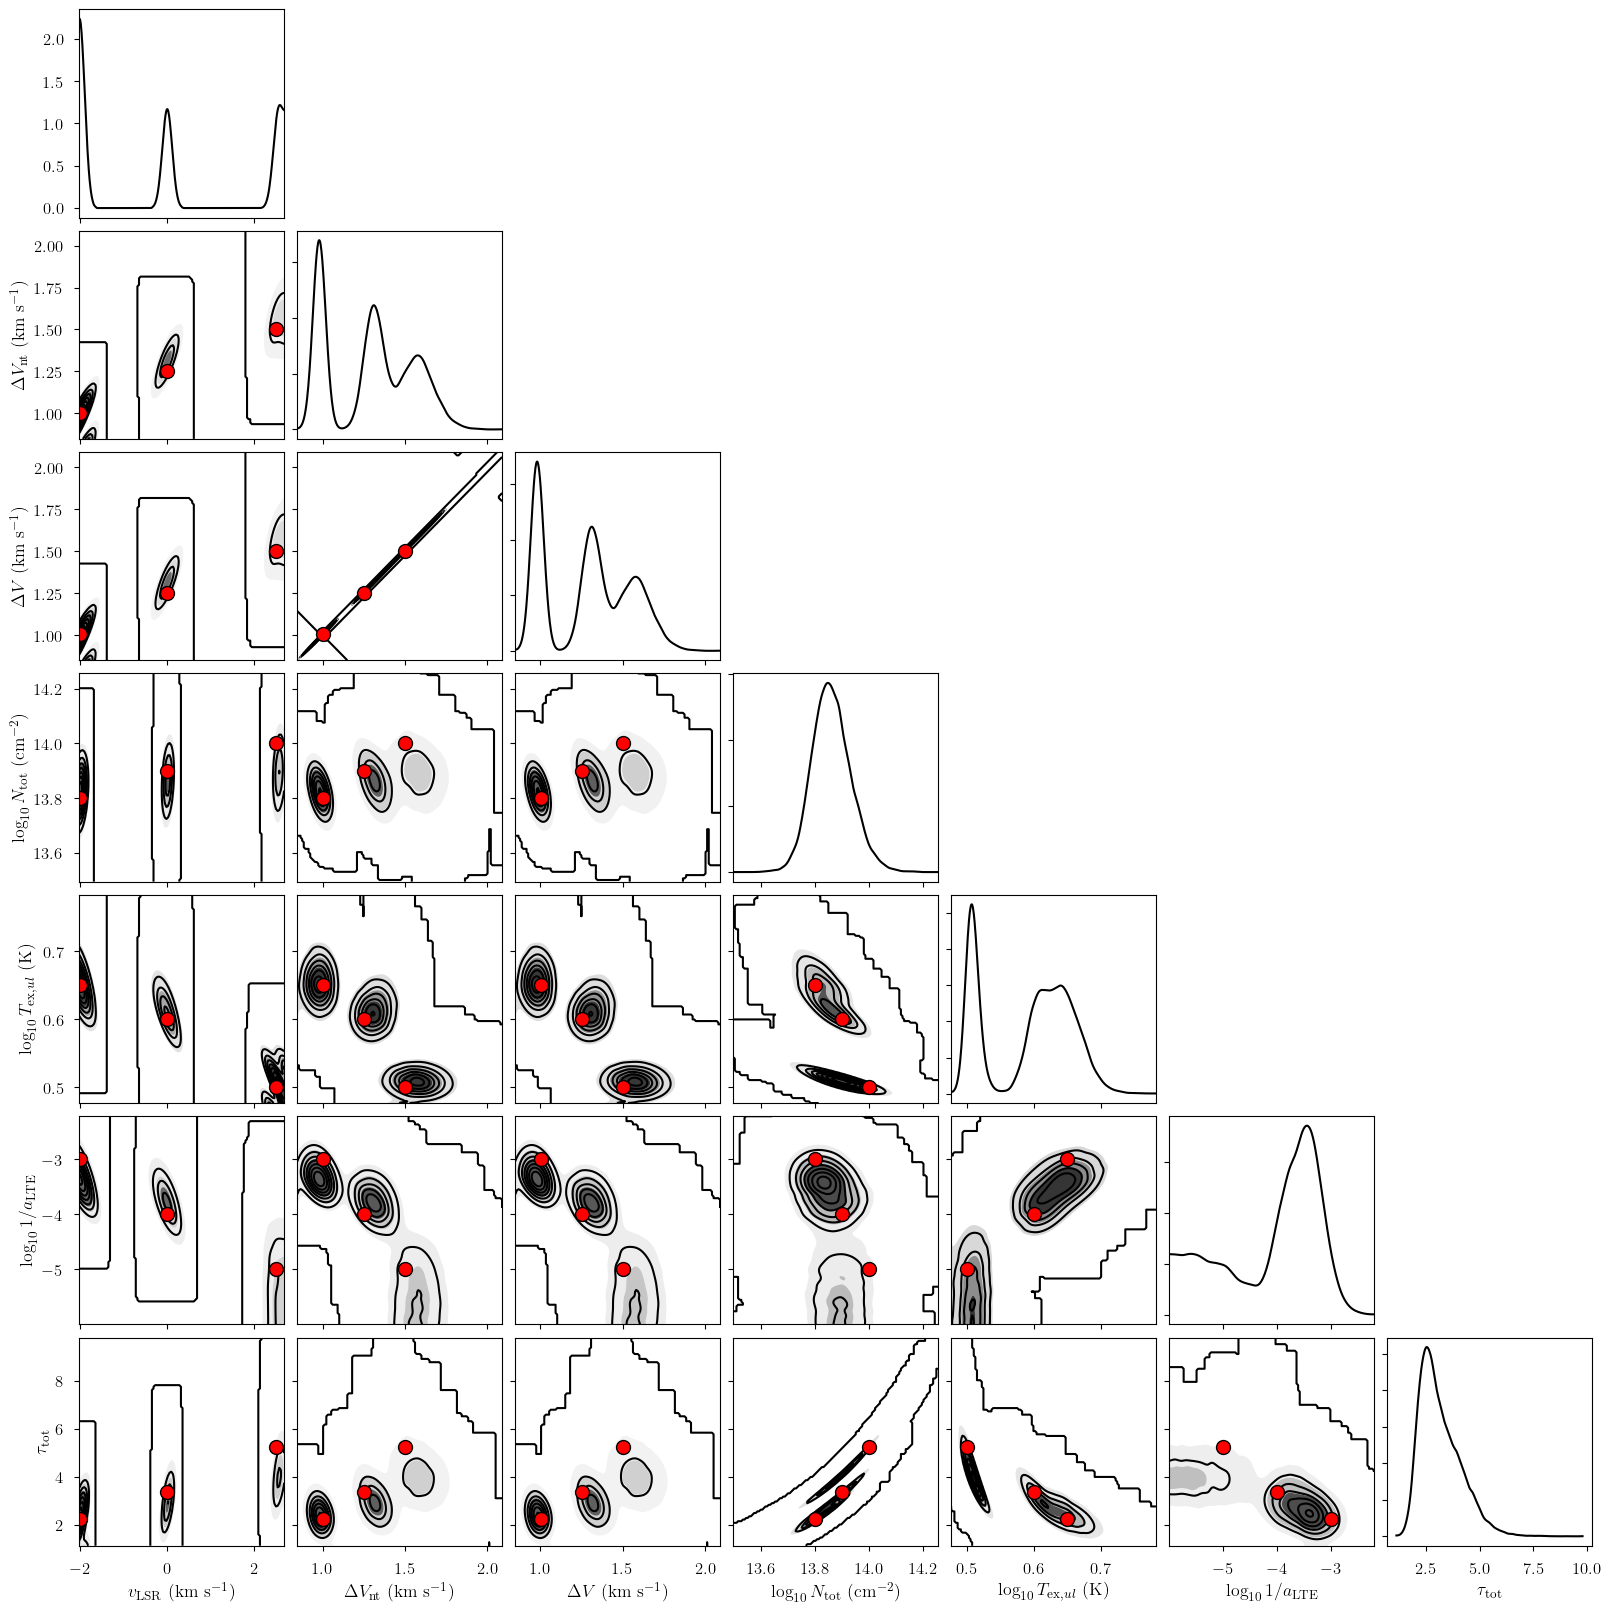

In [31]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

In [32]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(2), 1: np.int64(1), 2: np.int64(0)}

['velocity', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'log10_LTE_precision', 'tau_total']


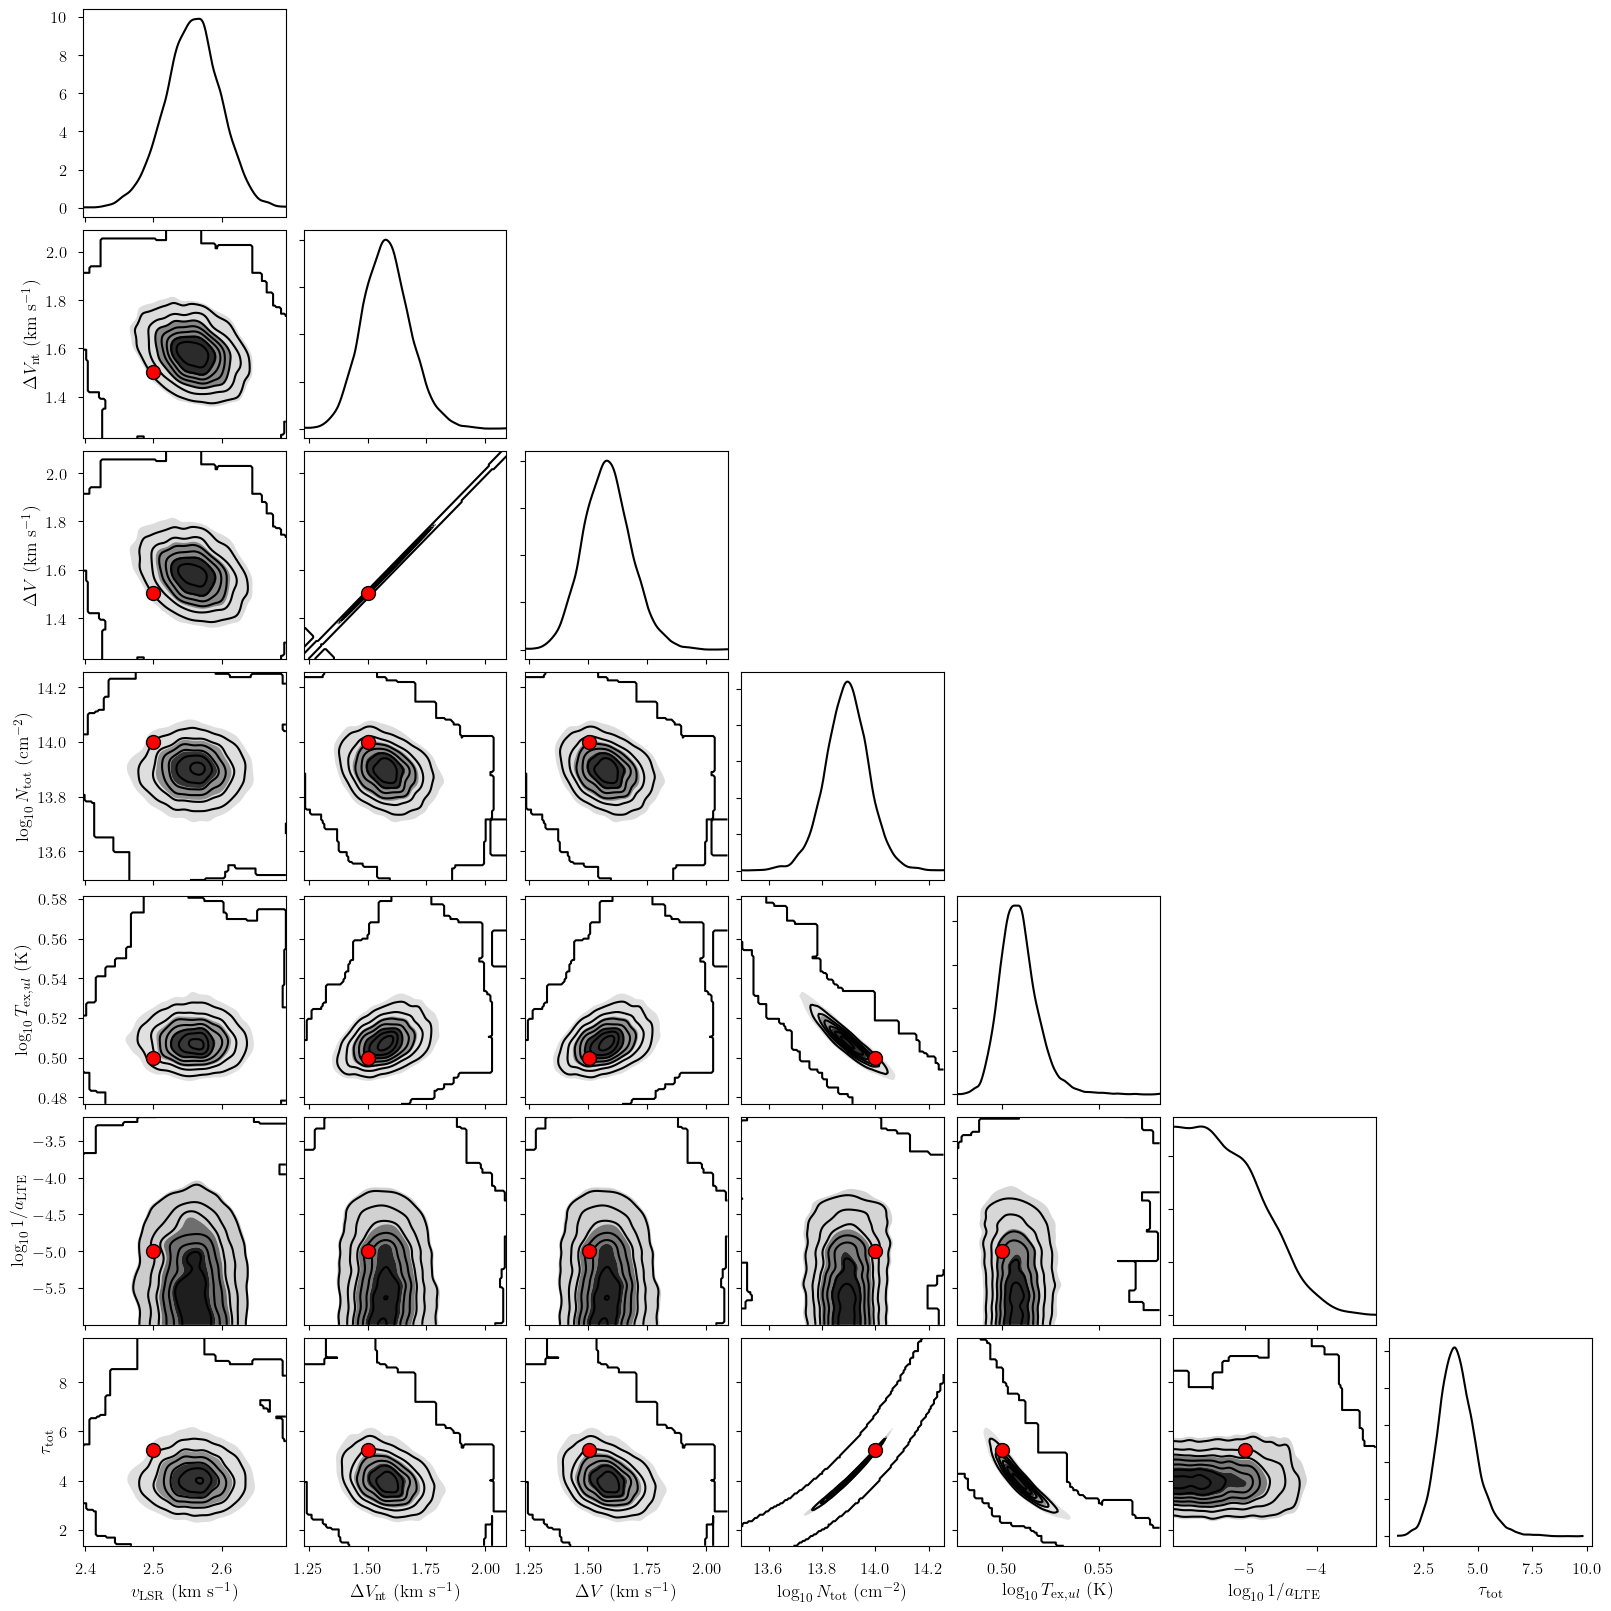

In [33]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

['velocity', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'log10_LTE_precision', 'tau_total']


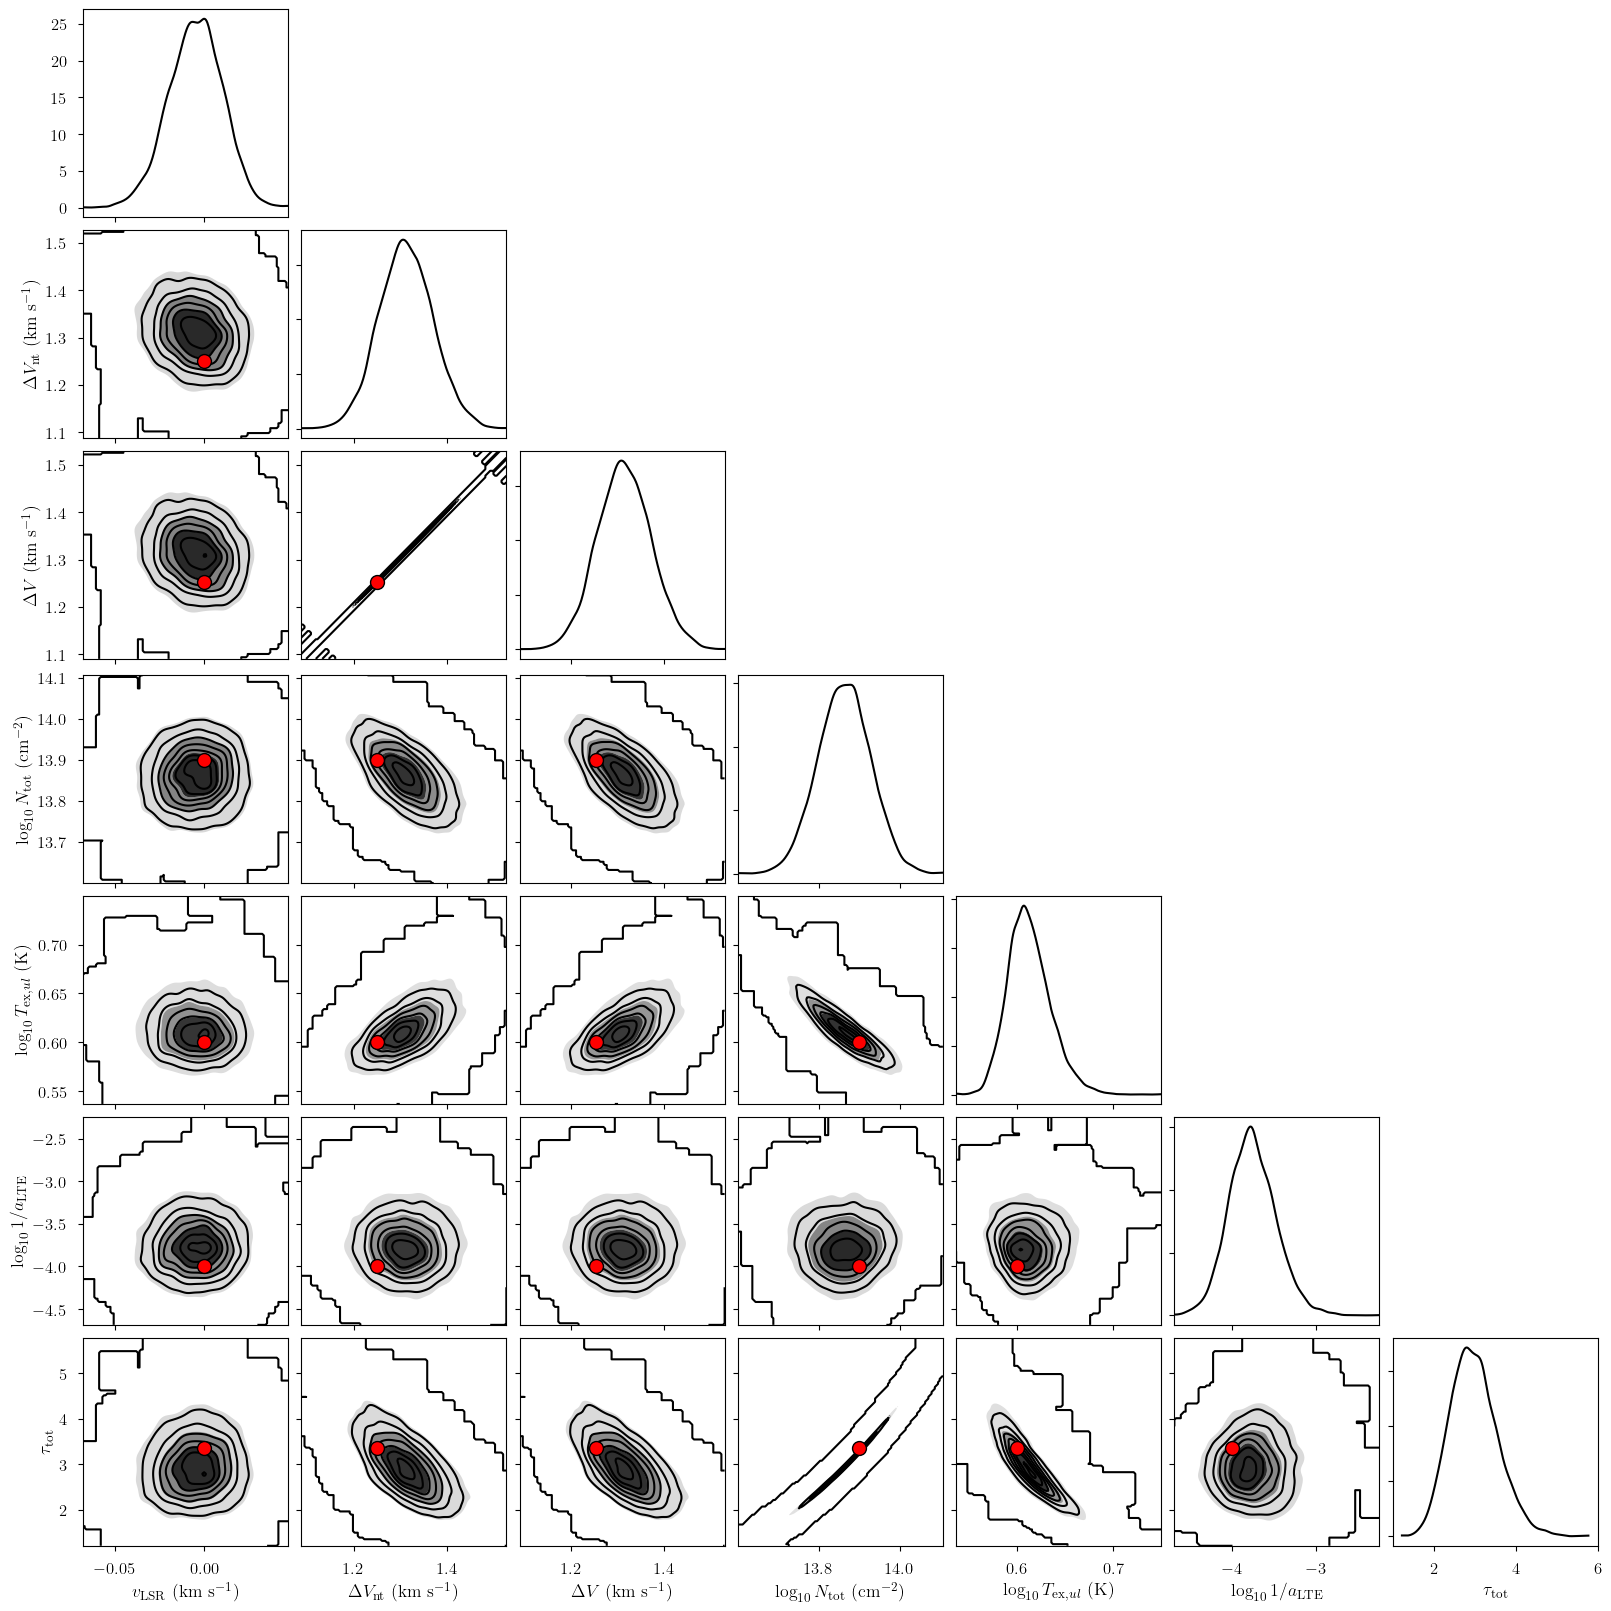

In [34]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

['velocity', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'log10_LTE_precision', 'tau_total']


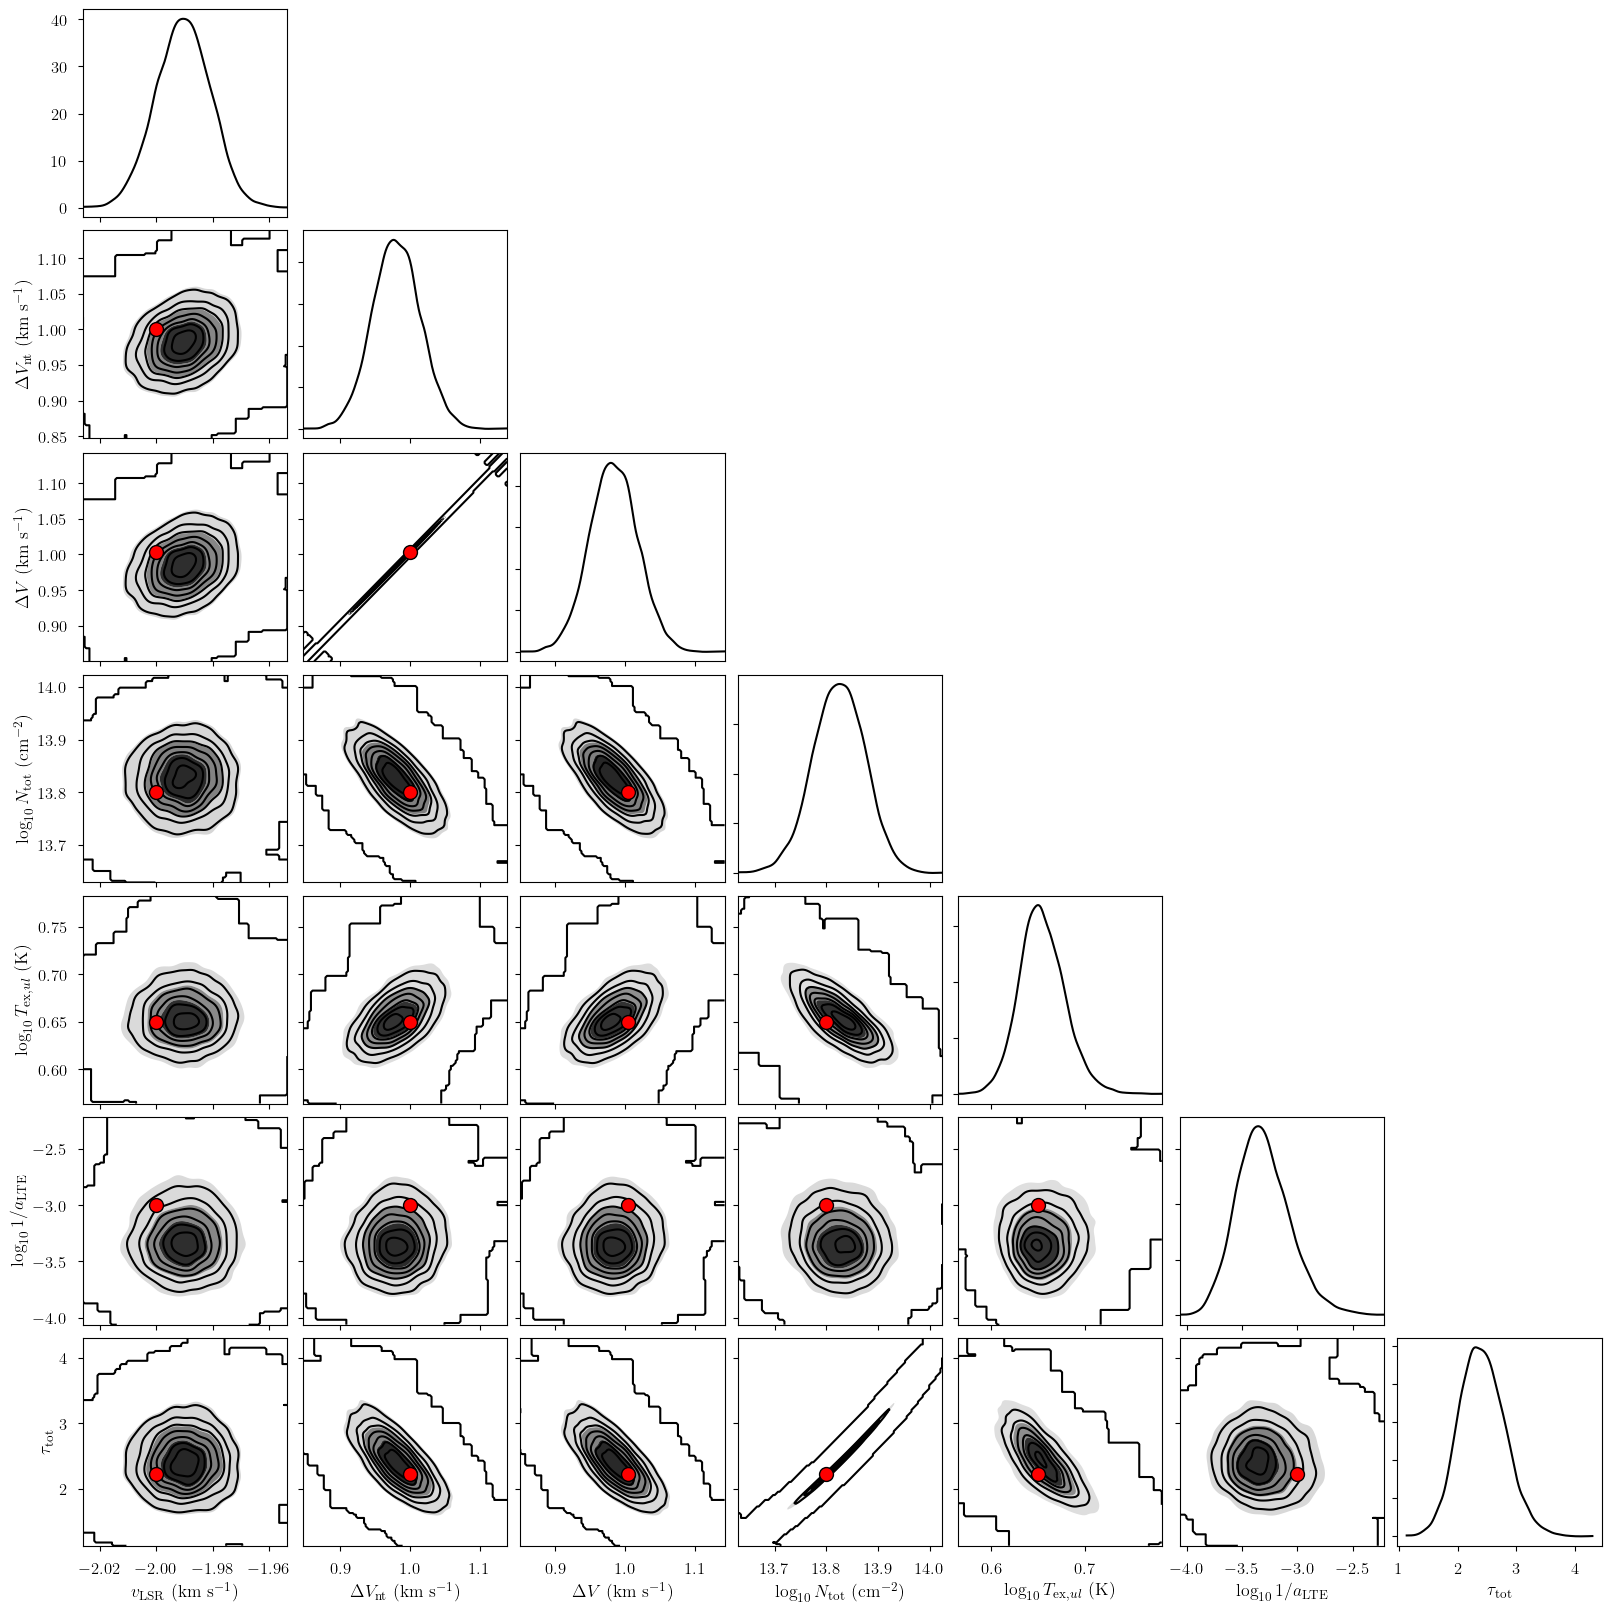

In [35]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

In [36]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3273.0262330955006


mean     sd  hdi_16%  hdi_84%
baseline_12CN-1_norm[0]      -0.076  0.044   -0.118   -0.030
baseline_12CN-2_norm[0]      -0.435  0.064   -0.499   -0.372
velocity_norm[0]              0.852  0.013    0.840    0.866
velocity_norm[1]             -0.002  0.005   -0.007    0.003
velocity_norm[2]             -0.663  0.003   -0.667   -0.660
log10_N_norm[0]               0.393  0.082    0.315    0.468
log10_N_norm[1]               0.363  0.065    0.298    0.425
log10_N_norm[2]               0.324  0.050    0.275    0.375
log10_Tex_ul_norm[0]          0.089  0.101   -0.022    0.155
log10_Tex_ul_norm[1]          1.128  0.221    0.897    1.310
log10_Tex_ul_norm[2]          1.546  0.249    1.294    1.763
fwhm_nonthermal_norm[0]       1.580  0.102    1.471    1.669
fwhm_nonthermal_norm[1]       1.312  0.058    1.258    1.372
fwhm_nonthermal_norm[2]       0.980  0.034    0.945    1.013
log10_LTE_precision_norm[0]   0.780  0.520    0.001    1.008
log10_LTE_precision_norm[1]   2.244  0.283    1.960    2.501
log10_LTE_precision_norm[2]   2.692  0.244    2.420    2.884
weights[0, 0 0 1 1]           0.214  0.003    0.211    0.217
weights[0, 0 0 1 2]           0.429  0.006    0.425    0.435
weights[0, 1 0 1 1]           0.040  0.001    0.038    0.041
weights[0, 1 0 1 2]           0.080  0.002    0.078    0.082
weights[0, 1 0 2 1]           0.040  0.001    0.038    0.041
weights[0, 1 0 2 2]           0.079  0.002    0.077    0.081
weights[0, 1 0 2 3]           0.119  0.003    0.116    0.121
weights[1, 0 0 1 1]           0.189  0.006    0.184    0.196
weights[1, 0 0 1 2]           0.368  0.010    0.360    0.379
weights[1, 1 0 1 1]           0.051  0.003    0.048    0.054
weights[1, 1 0 1 2]           0.101  0.005    0.096    0.105
weights[1, 1 0 2 1]           0.044  0.002    0.042    0.046
weights[1, 1 0 2 2]           0.097  0.004    0.093    0.101
weights[1, 1 0 2 3]           0.150  0.003    0.147    0.152
weights[2, 0 0 1 1]           0.178  0.005    0.174    0.184
weights[2, 0 0 1 2]           0.346  0.009    0.338    0.356
weights[2, 1 0 1 1]           0.054  0.002    0.051    0.056
weights[2, 1 0 1 2]           0.098  0.003    0.094    0.101
weights[2, 1 0 2 1]           0.045  0.002    0.043    0.047
weights[2, 1 0 2 2]           0.116  0.005    0.111    0.120
weights[2, 1 0 2 3]           0.163  0.002    0.160    0.165
velocity[0]                   2.557  0.040    2.521    2.599
velocity[1]                  -0.005  0.015   -0.020    0.010
velocity[2]                  -1.990  0.010   -2.000   -1.981
fwhm_thermal[0]               0.075  0.000    0.075    0.075
fwhm_thermal[1]               0.075  0.000    0.075    0.075
fwhm_thermal[2]               0.075  0.000    0.075    0.075
fwhm_nonthermal[0]            1.580  0.102    1.471    1.669
fwhm_nonthermal[1]            1.312  0.058    1.258    1.372
fwhm_nonthermal[2]            0.980  0.034    0.945    1.013
fwhm[0]                       1.581  0.102    1.473    1.670
fwhm[1]                       1.314  0.058    1.260    1.374
fwhm[2]                       0.983  0.034    0.948    1.016
log10_N[0]                   13.893  0.082   13.815   13.968
log10_N[1]                   13.863  0.065   13.798   13.925
log10_N[2]                   13.824  0.050   13.775   13.875
log10_Tex_ul[0]               0.509  0.010    0.498    0.516
log10_Tex_ul[1]               0.613  0.022    0.590    0.631
log10_Tex_ul[2]               0.655  0.025    0.629    0.676
LTE_weights[0, 0 0 1 1]       0.214  0.003    0.212    0.217
LTE_weights[0, 0 0 1 2]       0.429  0.006    0.424    0.435
LTE_weights[0, 1 0 1 1]       0.040  0.001    0.039    0.041
LTE_weights[0, 1 0 1 2]       0.080  0.002    0.078    0.081
LTE_weights[0, 1 0 2 1]       0.040  0.001    0.039    0.040
LTE_weights[0, 1 0 2 2]       0.079  0.002    0.077    0.081
LTE_weights[0, 1 0 2 3]       0.119  0.003    0.116    0.121
LTE_weights[1, 0 0 1 1]       0.186  0.006    0.181    0.192
LTE_weights[1, 0 0 1 2]       0.372  0.011    0.362    0.383
LTE_w